# Digit recognition - multiclass classification


## 1.1 Reading collected and MNIST datasets
  
  


In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from skimage.filters import threshold_otsu
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization, Reshape
from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation, RandomRotation, RandomWidth, RandomHeight, RandomZoom, Resizing

seed = 173
np.random.seed(seed)

In [2]:
df = pd.read_csv("data/drawings.csv")
mnist = pd.read_csv("data/train.csv")
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
5515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [3]:
'''
def binarize_mnist(image_collection):
    """
    Inverts a collection of images and makes it binary
    """

    imges = []

    for img in image_collection:
        # Retrieve an Otsu threshold for the image
        thresh = threshold_otsu(img)
        # Which pixels are beyond the threshold
        binary = img > thresh
        # Flatten
        imges.append(binary.reshape(28*28))

    return imges

# Pass the mnist dataframe into the binarizer and craft a dataframe
mnistBin = pd.DataFrame(binarize_mnist(np.array(mnist.iloc[:,1:]).reshape(len(mnist), 28, 28)))
'''

# Dividing by 255 yielded slightly better performance (about 0.01% better accuracy)
mnistBin = mnist.iloc[:,1:] / 255.0

In [4]:
# attach the appropriate label to each observation
mnistBin["label"] = mnist.label
# convert columns from bool to int
mnistBin = mnistBin + 0
mnistBin

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
41996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
41997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
41998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [5]:
# join the mnist and custom datasets, shuffle
jointDf = pd.DataFrame(np.concatenate([np.array(df), np.array(mnistBin)]))\
    .sample(frac=1, random_state=seed)\
        .reset_index(drop=True)\
            .rename({784: "label"}, axis=1)

In [6]:
jointDf

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
47514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
47515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Class balance

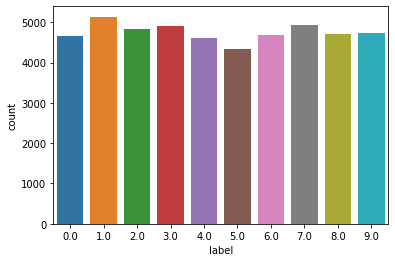

In [7]:
sns.countplot(x = jointDf.label);

#### Training and hold-out sets

In [8]:
y = to_categorical(jointDf.label)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(jointDf.iloc[:,:-1], y, train_size=0.9, random_state=seed) # no need to stratify for large balanced datasets
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42765, 784), (4752, 784), (42765, 10), (4752, 10))

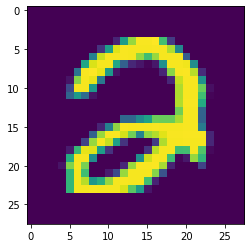

In [10]:
plt.imshow(np.array(x_test.sample(1, random_state=seed)).reshape(28, 28))

In [11]:
x_train = x_train.values.reshape(len(x_train), 28, 28, 1)

In [12]:
x_test = x_test.values.reshape(len(x_test), 28, 28, 1)

In [13]:
# Using ImageDataGenerator instead of dedicated CNN layers because validation data is typically not augmented
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.3,
                                                           height_shift_range=0.10,
                                                           width_shift_range=0.10,
                                                           rotation_range=10)

train_datagen = train_gen.flow(x_train, y_train, batch_size=256)

In [14]:
def get_model(seed):
        model = Sequential([                                
                Conv2D(64, 5, activation='relu', padding='same', input_shape=(28, 28, 1)),
                Conv2D(64, 5, activation='relu', padding='same'),
                Conv2D(64, 5, activation='relu', padding='same'),                
                MaxPool2D(2),
                BatchNormalization(),
                Conv2D(128, 5, activation='relu', padding='same'),
                Conv2D(128, 5, activation='relu', padding='same'),
                Conv2D(128, 5, activation='relu', padding='same'),                
                MaxPool2D(2),
                BatchNormalization(),
                
                # Decision-making
                tf.keras.layers.GlobalAveragePooling2D(), 
                Dense(128, activation='relu'),                
                Dense(10, activation="softmax")])


        
        opt = Adam(learning_rate = 0.001)
        model.compile(opt, "categorical_crossentropy", metrics=["accuracy"])

        return model

# Using LearningRateScheduler instead of ReduceLROnPlateau 
#lr_cut = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=2, verbose=1, min_lr=0.0000001, mode="max", cooldown=1)
quicksave = ModelCheckpoint(monitor="val_accuracy", filepath="data/checkpoint.hdf5", verbose=1)

model = get_model(seed)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       4

In [15]:
# The model tends to slightly overfit with LearningRateScheduler
def scheduler(epoch):    
    initial_lr = 0.001
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr

from tensorflow.keras.callbacks import LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

Text(0, 0.5, 'Learning rate')

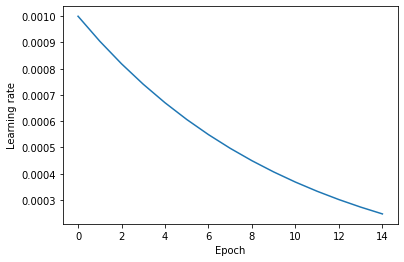

In [16]:
epochs = 15

lrs = scheduler(np.array(range(epochs)))

plt.plot(range(epochs), lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

In [17]:
hist = model.fit(train_datagen, initial_epoch=0, epochs=30, 
                 validation_data = (x_test, y_test), 
                 callbacks=[lr_scheduler, quicksave])

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
168/168 [==============================] - 19s 89ms/step - loss: 0.3185 - accuracy: 0.9028 - val_loss: 2.9381 - val_accuracy: 0.1397

Epoch 00001: saving model to data\checkpoint.hdf5
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009048374180359595.
168/168 [==============================] - 14s 82ms/step - loss: 0.0726 - accuracy: 0.9788 - val_loss: 0.8437 - val_accuracy: 0.7237

Epoch 00002: saving model to data\checkpoint.hdf5
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0008187307530779819.
168/168 [==============================] - 13s 80ms/step - loss: 0.0481 - accuracy: 0.9855 - val_loss: 0.1105 - val_accuracy: 0.9678

Epoch 00003: saving model to data\checkpoint.hdf5
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0007408182206817179.
168/168 [==============================] - 14s 82ms/step - loss: 0.0486 - accura

168/168 [==============================] - 16s 95ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.0137 - val_accuracy: 0.9962

Epoch 00030: saving model to data\checkpoint.hdf5


(0.0, 0.2)

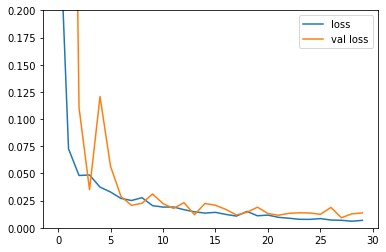

In [25]:
plt.plot(hist.history["loss"]);
plt.plot(hist.history["val_loss"]);
plt.legend(["loss", "val loss"]);
plt.ylim([0, 0.2])

(0.9, 1.0)

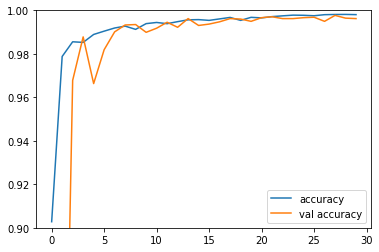

In [26]:
plt.plot(hist.history["accuracy"]);
plt.plot(hist.history["val_accuracy"]);
plt.legend(["accuracy", "val accuracy"]);
plt.ylim([0.9, 1])

In [20]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.3,
                                                           height_shift_range=0.10,
                                                           width_shift_range=0.10,
                                                           rotation_range=10)

test_datagen = test_gen.flow(x_test, y_test, batch_size=256)

In [21]:
model.evaluate(test_datagen)

19/19 [==============================] - 2s 90ms/step - loss: 0.0161 - accuracy: 0.9952


[0.016141826286911964, 0.995159924030304]